In [103]:
import numpy as np
from rayleighsommerfeld import rayleighsommerfeld
import pandas as pd
import trackpy as tp

#graphical:
import matplotlib.pyplot as plt
from matplotlib import colors
#from skimage import io

from itertools import chain
import pickle
from time import process_time

### 1. Set appropriate filename, create empty dataframe

In [218]:
kwd = '101823_coalescence' #keyword from name of normalized folder
parent = './{}_norm_images/'.format(kwd) #change location to the folder here
filename = kwd #filename for .npy object to which we will be saving results
#df = pd.DataFrame() #make sure to comment this once you run.

### 2. Display cropped image for specific timeframe

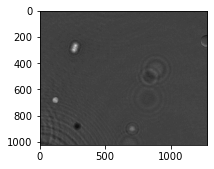

In [644]:
def show_small(im, axis_state):
    fig, ax = plt.subplots(figsize = (3,3))
    ax.imshow(im, cmap = 'gray')
    ax.axis(axis_state)
    
framenum = 1080
image = 'image{}'.format(str(framenum).zfill(4))
num_monomers = 2 #fixed at 2 for dimers
fg = plt.imread(parent+image+'.png')
show_small(fg, 'on')

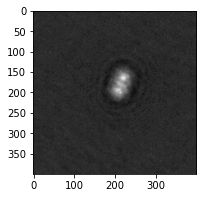

In [645]:
#manual crop, based on image above
xmin, ymin = 50, 100
dx, dy = 400, 400
fg_cropped = 10*fg[ymin:ymin+dy, xmin:xmin+dx]
show_small(fg_cropped, 'on')

### 3. Run Rayleigh Sommerfeld Backpropagation

In [646]:
t1_start = process_time() 

#don't change these setting mid-experiment. Note them down so we know what the best
    #axial resolution is.
zmin = -10.
zmax = 0.
n = 200 
mpp = .048

z = np.linspace(zmin, zmax, n)/mpp

a = fg_cropped
out = rayleighsommerfeld(a, z, magnification = mpp, nozphase = True)
bz = np.abs(out).astype(float)
print(bz.shape)
phi = np.angle(out - 1.)

t1_stop = process_time()
print("Elapsed time during the whole program in seconds:", t1_stop-t1_start) 

(400, 400, 200)
Elapsed time during the whole program in seconds: 3.796875


### 4. Display slices along optical axis in GUI

In [649]:
#this bit will not work if you don't have pyqt installed. It is a crucial bit of the process because we start by
    #guessing axial positions of dimers.
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg
app = QApplication.instance() or QApplication()

#widget to view slices. Keep scanning until intensity is maximized, and note those indices for each particle
widget = pg.ImageView()
widget.setImage(bz.T)
widget.show()

### 5. Use trackpy to locate 2D features

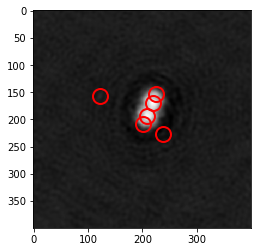

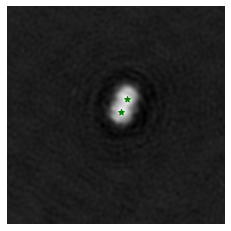

In [650]:
z0 = 162 #rough estimate of axial position of first particle
b = bz[:, :, z0]
f = tp.locate(b, 13, minmass = 7, invert=False)
tp.annotate(f, b); #if needed to 

thresh = (f['raw_mass'].nlargest(2).iloc[-1])
dthresh = 10
f = f[f['raw_mass']>thresh-dthresh]

plt.imshow(b, cmap = 'gray')
plt.scatter(np.array(f.x), np.array(f.y), marker='*', color='green')
plt.axis('off');

x_res, y_res = list(np.array(f.x)), list(np.array(f.y))

### 6. Look at intensity (or gradient of intensity) along optical axis, and find focus.

[(12.9213081998115, 12.924226201696513, 0.7999999999999989), (12.396608632234965, 14.072659285288074, 0.9000000000000004)]
1.266573402414019


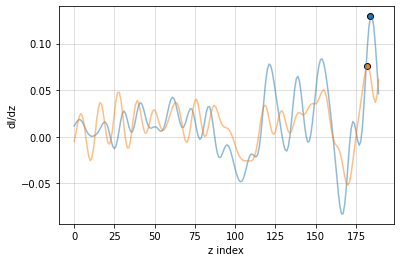

In [651]:
n = 200

pick = 'noint' #'int' if we want to go the intensity route, instead of gradient of intensity. 
    #why would you use 'int'? The theory says gradient of intensity is what needs to be maximized to find centroid.
    #for some samples, the data may be too noisy, and we might want to track intensity instead. The two answers
    #should only differ by a constant.

frame = []
for i in range(num_monomers):
        
    #true (x,y) values based on 1280x1024 coordinate system. Values in microns
    x = (x_res[i]+xmin)*mpp
    y = (y_res[i]+ymin)*mpp
    
    #bz has shape (dy,dz,n)
    intensity_list = bz[int(y_res[i]), int(x_res[i]), :]
    phi_list = phi[int(y_res[i]), int(x_res[i]), :]
    
    smallz = 5
    dIdz = np.diff(intensity_list, n=1)[smallz:n-smallz] #gradient of intensity
    I=intensity_list[smallz:n-smallz]
    
    if pick == 'int':
        plt.plot(I, alpha = .5)
        plt.xlabel('z index')
        plt.ylabel('intensity')
        zi = [i for i, x in enumerate(I) if x == max(I)][0] #find global peak

    else:
        plt.plot(dIdz, alpha = .5)
        plt.xlabel('z index')
        plt.ylabel('dI/dz')
        zi = [i for i, x in enumerate(dIdz) if x == max(dIdz)][0] #find global peak
         
    z = abs(zmin + (zi/n)*(zmax-zmin))

    if pick == 'int':
        plt.scatter([zi], [I[zi]], edgecolor = 'k')
    else:
        plt.scatter([zi], [dIdz[zi]], edgecolor = 'k')
    plt.grid(alpha =.5)

    frame.append((x,y,z))

print(frame)
a, b = frame
print(np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2))

### 7. Save to dataframe

In [652]:
dict_frame = {'t': [framenum/30], 'x0': a[0], 'y0': a[1], 'z0': a[2], 'x1': b[0], 'y1': b[1], 'z1': b[2]}
df_frame = pd.DataFrame(dict_frame)
print(df_frame)

      t         x0         y0   z0         x1         y1   z1
0  36.0  12.921308  12.924226  0.8  12.396609  14.072659  0.9


In [653]:
df = pd.concat([df, df_frame])
df = df.sort_values(by=['t'])

#there might be some weird column names because of saving issues. Delete them
final_table_columns = ['t', 'x0', 'x1', 'y0', 'y1', 'z0', 'z1']
df = df.drop(columns=[col for col in df if col not in final_table_columns])

df.to_csv('{}.csv'.format(filename))  

### 8. Plot quantities of interest. E.g. here, we are tracking the distance of separation between the two centroids of coalescing condensates with time.

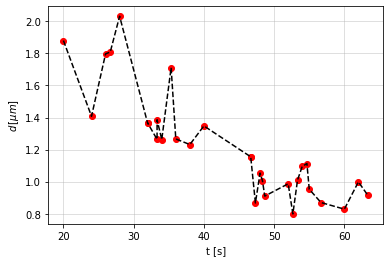

In [654]:
times = np.array(df['t'])
d = np.sqrt((np.array(df['x0'])-np.array(df['x1']))**2 + (np.array(df['y0'])-np.array(df['y1']))**2 +\
(np.array(df['z0'])-np.array(df['z1']))**2)
plt.plot(times, d, 'ro')
plt.plot(times, d, 'k--')
plt.xlabel('t [s]')
plt.ylabel(r'$d\,[\mu m$]')
plt.grid(alpha=.5)